## Overview
We've included analysis code used to replicate the results and all figures for Ma and Mortimer et al., 2020 ("Increased antibiotic susceptibility in Neisseria gonorrhoeae through adaptation to the cervical environment"). Please reach out with any questions to kevinchenma@g.harvard.edu and we'll be happy to assist.

## Dependencies and genomics pipeline

First, we'll give a brief overview of the genomics pipeline. Since these are mostly based off existing tools, we won't go step by step through them but wuold be happy to share additional code on request. The end result of the pipeline will be mapping-based pseudogenomes and de novo assemblies for each isolate.

We used the following Python packages extensively. We also used rpy2 to run R code within the Jupyter notebook, but this is optional.

In [ ]:
import numpy as np
import statsmodels
import statsmodels.formula.api as smf
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
from Bio import SeqIO
from collections import Counter
%matplotlib inline

We used BLASTn (version 2.6.0) extensively. We set up a BLASTn database using all of the contigs in our dataset; we did not upload this to Github due to size constraints but would be happy to provide it directly upon request.

To call mosaic alleles in penA / mtrRCDE, we used MAFFT (version 7.450) and fastBAPS (version 1.0.0). Make sure the dependencies for fastBAPS are installed as well.

For the GWAS portion, we additionally installed the dependencies required for Pyseer, re-listed here (https://pyseer.readthedocs.io/en/master/installation.html#prerequisites):

- python 3+ (3.5.3)
- numpy (1.13.3)
- scipy (1.0.0)
- pandas (0.21.0)
- scikit-learn (0.19.1)
- statsmodels (0.8.0)
- pysam (0.13)
- matplotlib (2.1.0) – for scree plots
- DendroPy (4.3.0) – for phylogeny distances
- pybedtools (0.7.10) – for annotating k-mers
- bedtools (2.27.0) – for annotating k-mers
- bedops (2.4.9) – for annotating k-mers

### Calling SNP-based resistance genes

### fastBAPS clustering of mosaic alleles

We used fastBAPS to cluster nucleotide sequences of penA and the mtrRCDE operon for usage as a covariate in the linear regression MIC prediction models. This provided a flexible, categorical representation of the mosaic alleles without needing to explicitly map to and identify known alleles. Because this is a bit different than other resistance allele calling approaches, we've included all of the necessary code below.

#### mosaic mtrRCDE

First, we pulled out the whole mtrR through mtrCDE nucleotide sequence using a query sequence from reference strain FA1090 and the BLASTn database of the contigs, and converted the results to a FASTA file after some minor quality control for length.

In [34]:
!blastn -db blast/2019-08-26_combined-contigs.fna -query linear-models/covariates/FA1090-mtrprom-mtrCDE.fna -num_descriptions 10000 -num_alignments 10000 -out linear-models/covariates/mtr-combined.txt
!blastn -db blast/2019-08-26_combined-contigs.fna -query linear-models/covariates/FA1090-mtrprom-mtrCDE.fna -outfmt '6 sseqid length evalue sseq' -max_target_seqs 10000 -out linear-models/covariates/mtr-combined.tsv

In [35]:
samples = []
with open('linear-models/covariates/mtr-combined.fna', 'w') as outfile, open('linear-models/covariates/mtr-combined.tsv', 'r') as infile:
    for line in infile:
        name,length,evalue,fasta = line.rstrip().split('\t')
        if int(length) < 4000:
            continue
        else:
            outfile.write('>' + name.split('|')[0] + '\n')
            outfile.write(fasta + '\n')
            if name in samples:
                print('Duplicate ' + name)
            else:
                samples.append(name)

We aligned the FASTA file using MAFFT and passed it to fastBAPS for clustering using R. This will give a table of samples and the corresponding fastBAPS cluster for the mtrRCDE operon.

In [42]:
!software/mafft-linux64/mafft.bat linear-models/covariates/mtr-combined.fna > linear-models/covariates/mtr-combined-aligned.fna

nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8192 kb
generating a scoring matrix for nucleotide (dist=200) ... done
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..
 4901 / 4941
done.

Constructing a UPGMA tree (efffree=0) ... 
 4930 / 4941
done.

Progressive alignment 1/2... 
STEP  4801 / 4940  h
Reallocating..done. *alloclen = 10553
STEP  4901 / 4940 
done.

Making a distance matrix from msa.. 
 4900 / 4941
done.

Constructing a UPGMA tree (efffree=1) ... 
 4930 / 4941
done.

Progressive alignment 2/2... 
STEP  4901 / 4940  h
Reallocating..done. *alloclen = 10552

done.

disttbfast (nuc) Version 7.450
alg=A, model=DNA200 (2), 1.53 (4.59), -0.00 (-0.00), noshift, amax=0.0
0 thread(s)


Strategy:
 FFT-NS-2 (Fast but rough)
 Progressive method (guide trees were built 2 times.)

If unsure which option to use, try 'mafft --auto input > output'.
For more information, see 'mafft --help', 'mafft --man' and the mafft page.

The default gap scoring schem

In [43]:
%load_ext rpy2.ipython

In [48]:
%%R -w 8 -h 4 --units in -r 400

library(fastbaps)
library(ape)

sparse.data <- import_fasta_sparse_nt("linear-models/covariates/mtr-combined-aligned.fna")
sparse.data <- optimise_prior(sparse.data, type = "optimise.symmetric")

baps.hc <- fast_baps(sparse.data)

clusters <- best_baps_partition(sparse.data, as.phylo(baps.hc))

write.table(clusters, file = "linear-models/covariates/mtr-combined-fastBAPS.csv", row.names = TRUE, sep = ',', quote = FALSE, col.names = FALSE)

[1] "Optimised hyperparameter: 0.009"
[1] "Calculating initial clustering..."
[1] "Calculating initial dk values..."
[1] "Clustering using hierarchical Bayesian clustering..."
[1] "Calculating node marginal llks..."
[1] "Finding best partition..."


In [50]:
!head linear-models/covariates/mtr-combined-fastBAPS.csv

FA1090,10
SRR3360687,10
ERR388284,10
ERR388345,10
ERR349956,10
ERR388402,10
ERR349937,10
ERR388321,10
ERR349942,10
SRR3361345,10


#### mosaic penA

We used the same pipeline for identifying mosaic penA clusters.

In [51]:
!blastn -db blast/2019-08-26_combined-contigs.fna -query linear-models/covariates/FA1090-penA.fna -num_descriptions 10000 -num_alignments 10000 -out linear-models/covariates/penA-combined.txt
!blastn -db blast/2019-08-26_combined-contigs.fna -query linear-models/covariates/FA1090-penA.fna -outfmt '6 sseqid length evalue sseq' -max_target_seqs 10000 -out linear-models/covariates/penA-combined.tsv

In [53]:
samples = []
with open('linear-models/covariates/penA-combined.fna', 'w') as outfile, open('linear-models/covariates/penA-combined.tsv', 'r') as infile:
    for line in infile:
        name,length,evalue,fasta = line.rstrip().split('\t')
        if int(length) < 1500:
            continue
        else:
            outfile.write('>' + name.split('|')[0] + '\n')
            outfile.write(fasta + '\n')            
            if name in samples:
                print('Duplicate ' + name)
            else:
                samples.append(name)

In [55]:
!software/mafft-linux64/mafft.bat linear-models/covariates/penA-combined.fna > linear-models/covariates/penA-combined-aligned.fna

nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8192 kb
generating a scoring matrix for nucleotide (dist=200) ... done
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..
 4901 / 4914
done.

Constructing a UPGMA tree (efffree=0) ... 
 4910 / 4914
done.

Progressive alignment 1/2... 
STEP  4901 / 4913  h
done.

Making a distance matrix from msa.. 
 4900 / 4914
done.

Constructing a UPGMA tree (efffree=1) ... 
 4910 / 4914
done.

Progressive alignment 2/2... 
STEP  4901 / 4913 
done.

disttbfast (nuc) Version 7.450
alg=A, model=DNA200 (2), 1.53 (4.59), -0.00 (-0.00), noshift, amax=0.0
0 thread(s)


Strategy:
 FFT-NS-2 (Fast but rough)
 Progressive method (guide trees were built 2 times.)

If unsure which option to use, try 'mafft --auto input > output'.
For more information, see 'mafft --help', 'mafft --man' and the mafft page.

The default gap scoring scheme has been changed in version 7.110 (2013 Oct).
It tends to insert more gaps into gap-rich regions

In [70]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [56]:
%%R -w 8 -h 4 --units in -r 400

library(fastbaps)
library(ape)

sparse.data <- import_fasta_sparse_nt("linear-models/covariates/penA-combined-aligned.fna")
sparse.data <- optimise_prior(sparse.data, type = "optimise.symmetric")

baps.hc <- fast_baps(sparse.data)

clusters <- best_baps_partition(sparse.data, as.phylo(baps.hc))

write.table(clusters, file = "linear-models/covariates/penA-combined-fastBAPS.csv", row.names = TRUE, sep = ',', quote = FALSE, col.names = FALSE)

[1] "Optimised hyperparameter: 0.003"
[1] "Calculating initial clustering..."
[1] "Calculating initial dk values..."
[1] "Clustering using hierarchical Bayesian clustering..."
[1] "Calculating node marginal llks..."
[1] "Finding best partition..."


In [57]:
!head linear-models/covariates/penA-combined-fastBAPS.csv

FA1090,14
ERR388323,14
ERR363579,14
ERR449525,14
ERR349961,14
ERR349925,14
ERR388339,14
ERR388346,14
ERR388446,14
ERR449514,14


## Dataset overview and phenotype filtering

### Overview of metadata

We read in the metadata file for the global dataset; there should be 4852 samples included.

In [71]:
import numpy as np
import statsmodels
import statsmodels.formula.api as smf
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
from Bio import SeqIO
from collections import Counter
%matplotlib inline

In [14]:
metadata = pd.read_csv('metadata/2020-04-27_Supplementary-Table-6_Global-Strain-Collection.csv')
metadata.shape

(4852, 16)

### Timespan
A summary of the timespan of collection and number of strains per dataset:

In [15]:
metadata['Year_only'] = metadata['Year'].apply(lambda x: float(str(x).split('-')[0]))

for dataset in Counter(metadata['Reference']):
    years = sorted(metadata[metadata['Reference'] == dataset].Year_only)
    print(min(years), max(years), dataset, len(years))

1989.0 2013.0 Demczuk2015 114
1991.0 2014.0 Demczuk2016 199
2004.0 2011.0 Eyre2017 231
1982.0 2011.0 Ezewudo2015 54
2004.0 2017.0 Fifer2018 50
2000.0 2013.0 Grad2014_2016 1100
2013.0 2013.0 Harris2018 1048
2006.0 2014.0 Kwong2017 94
2014.0 2015.0 Lee2018 397
2011.0 2015.0 MortimerUnpub 888
2012.0 2016.0 Ryan2018 39
1979.0 2012.0 SanchezBuso2018 378
1996.0 2015.0 Yahara2018 260


Number of isolates collected by year:

/home/kcm14/anaconda3/envs/pyseer/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/kcm14/anaconda3/envs/pyseer/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


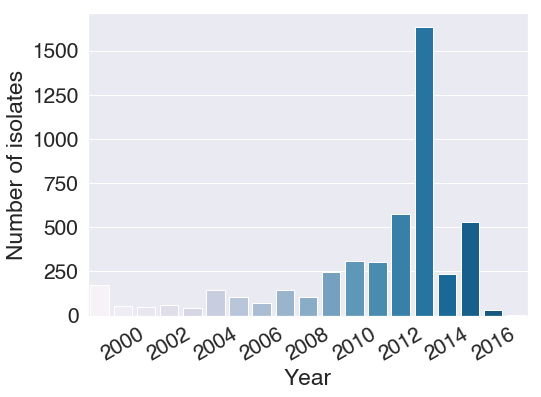

In [16]:
sns.set(font_scale = 1.9)

plotmetadata = metadata[pd.notnull(metadata['Year_only'])]
plotmetadata['Year_only'] = plotmetadata['Year_only'].apply(lambda x: (int(float(str(x).split('-')[0]))))
plotmetadata['Year_only'] = plotmetadata['Year_only'].apply(lambda x: str(x) if x >= 2000 else '1979-1999')

fig, ax = plt.subplots(figsize=(8,6))
sns.set_style({'font.sans-serif': 'helvetica'})

sns.countplot(sorted(plotmetadata['Year_only']), ax=ax, palette=sns.color_palette("PuBu", 20))

plt.xticks(rotation=30)
plt.ylabel('Number of isolates')
plt.xlabel('Year')
for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)

sns.set_style({'font.sans-serif': 'helvetica'})
plt.tight_layout()

### Geographical range

Number of isolates collected by continent for the most frequent continents:

/home/kcm14/anaconda3/envs/pyseer/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


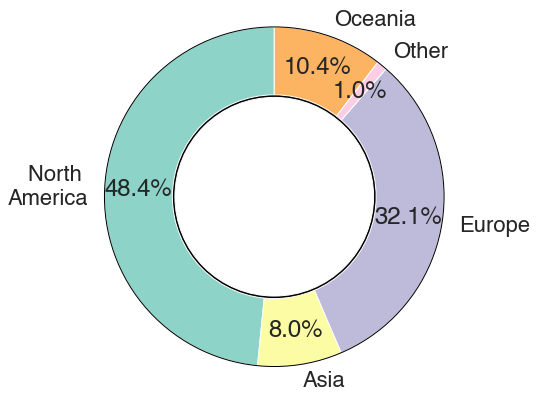

In [69]:
sns.set(font_scale = 2)
sns.set_style({'font.sans-serif': 'helvetica'})

plotmetadata2 = metadata[pd.notnull(metadata['Continent'])]
plotmetadata2['Continent2'] = plotmetadata2['Continent'].apply(lambda x: x if x in ['North America', 'Asia', 'Europe', 'Oceania'] else 'Other')

fig, ax = plt.subplots(figsize=(8,6))

centre_circle3 = plt.Circle((0,0),1.0,ec='black', fill=False)
fig.gca().add_artist(centre_circle3)

labels = ['North \nAmerica', 'Asia', 'Europe', 'Other', 'Oceania']
sizes = list(Counter(plotmetadata2['Continent2']).values())
colors = ['#8dd3c7','#fcfca4','#bebada','#fccde5', '#fdb462']
explode = (0,0,0,0)
 
plt.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.80)
centre_circle = plt.Circle((0,0),0.585,fc='white')
centre_circle2 = plt.Circle((0,0),0.60,fc='black')
fig.gca().add_artist(centre_circle2)
fig.gca().add_artist(centre_circle)

plt.axis('equal')  
plt.tight_layout()

Number of countries included:

In [23]:
len(Counter(metadata['Country']))

65

### Phenotype processing

We took a few filtering steps to clean up and standardize the MICs. Some isolates only had binary 'RES' or 'SUS' information; we removed those samples. Some isolates only had relative MIC values (e.g., >=8); we set those to be equal to the provided threshold (i.e., 8). We also log2-transformed MICs for both linear modeling and GWAS. Finally, for azithromycin, we multiplied MICs of CDC GISP isolates prior to 2005 by two as previously done (Grad et al., 2016) to account for a known change in the MIC measurement media protocol.

In [68]:
import pandas as pd
import numpy as np

metadata_filtered = pd.read_csv('metadata/2020-04-27_Supplementary-Table-6_Global-Strain-Collection.csv')
metadata_filtered = metadata_filtered.replace('SUS', np.nan)
metadata_filtered = metadata_filtered.replace('RES', np.nan)

metadata_filtered['AZI_LOG'] = metadata_filtered['Azithromycin'].map(lambda x: float(str(x).lstrip('><=')))

adjusted_MIC = []
for index, row in metadata_filtered.iterrows():
    if not row['Reference'].startswith('Grad'):
        adjusted_MIC.append(row['AZI_LOG'])
    else:
        if int(row['Year']) < 2005:
            adjusted_MIC.append(2*row['AZI_LOG'])
        else:
            adjusted_MIC.append(row['AZI_LOG'])
            
metadata_filtered['AZI_LOG'] = adjusted_MIC
metadata_filtered['AZI_LOG'] = np.log2(metadata_filtered['AZI_LOG'])

metadata_filtered['CRO_LOG'] = np.log2(metadata_filtered['Ceftriaxone'].map(lambda x: float(str(x).lstrip('><='))))
metadata_filtered['CIP_LOG'] = np.log2(metadata_filtered['Ciprofloxacin'].map(lambda x: float(str(x).lstrip('><='))))

metadata_filtered.to_csv('metadata/strain-table-filtered.csv', index=False)
metadata_filtered.to_csv('metadata/gwas-strain-table-filtered.csv', index=False, columns=['GWAS_ID', 'AZI_LOG', 'CRO_LOG', 'CIP_LOG'])

We are left with the following number of samples for each drug for linear modeling / GWAS.

In [67]:
metadata_filtered.count()[-3:]

AZI_LOG    4505
CRO_LOG    4497
CIP_LOG    4135
dtype: int64

## Linear modeling

We first used a regression model based on the known resistance determinants to assess how much resistance / susceptibility was already explained, in order to motivate usage of GWAS. To do this we make use of the previously called resistance alleles. We've summarized those for our dataset in the linear-models/covariates/combined-covariates.csv file.

In [1]:
import numpy as np
import statsmodels
import statsmodels.formula.api as smf
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
from Bio import SeqIO
from collections import Counter
%matplotlib inline

### Azithromycin

We read in the covariates and the MIC file and subset to strains with azithromycin MICs (n=XXXX). After setting baseline levels for the factors to facilitate interpretation, we run regression comparing the model fits with and without inclusion of mtrC LOF alleles.

In [34]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [37]:
%%R -o azi_df -w 8 -h 4 --units in -r 400

library(tidyverse)
library(dplyr)
library(ggplot2)

azi_df = read.table("linear-models/covariates/combined-covariates.csv", sep=",", header=TRUE, comment.char="", na.strings=c("", "NA"), stringsAsFactors=FALSE)
pheno = read.table("metadata/strain-table-filtered.csv", sep=",", header=TRUE, comment.char="", na.strings=c("", "NA"), stringsAsFactors=FALSE)
pheno <- pheno %>%
    select(GWAS_ID, AZI_LOG, CRO_LOG, CIP_LOG, MtrC)

azi_df <- azi_df %>% 
    left_join(pheno, by = c("GWAS_ID")) %>% 
    select(GWAS_ID, Country, AZI_LOG, MtrR_39, MtrR_45, RplD_70, mtr_promoter, 
           mtrR, Mosaic_Mtr_BAPS, rRNA23S_2059, rRNA23S_2611, MtrC) %>%
    filter(!is.na(AZI_LOG)) %>%

   replace(is.na(.), "Unmapped") %>% # Some mosaic alleles do not map well in SNP calling

    within(., Country <- relevel(factor(Country), ref = "USA")) %>% # Relevel baseline factors to faciliate interpretation
    within(., MtrR_39 <- relevel(factor(MtrR_39), ref = "A")) %>%
    within(., MtrR_45 <- relevel(factor(MtrR_45), ref = "G")) %>% 
    within(., RplD_70 <- relevel(factor(RplD_70), ref = "G")) %>% 
    within(., mtr_promoter <- relevel(factor(mtr_promoter), ref = "A")) %>%
    within(., mtrR <- relevel(factor(mtrR), ref = "full_length")) %>%
    within(., Mosaic_Mtr_BAPS <- relevel(factor(Mosaic_Mtr_BAPS), ref = "11")) %>%
    within(., MtrC <- relevel(factor(MtrC), ref = "Intact"))

print(dim(azi_df))
head(azi_df, n=10)

[1] 4505   12
      GWAS_ID Country   AZI_LOG MtrR_39 MtrR_45 RplD_70 mtr_promoter        mtrR Mosaic_Mtr_BAPS rRNA23S_2059 rRNA23S_2611   MtrC
1  SRR1661153  Canada -1.000000       A       D       G            - full_length              11            0            0 Intact
2  SRR1661154  Canada -2.000000       T       G       G            - full_length              11            0            0 Intact
3  SRR1661155  Canada  0.000000       A       G       G            - full_length              11            0            0 Intact
4  SRR1661156  Canada -2.000000       T       D       G            - full_length              11            0            0 Intact
5  SRR1661157  Canada -3.000000       A       G       G     Unmapped full_length              11            0            0 Intact
6  SRR1661158  Canada -2.000000       A       D       G            - full_length              11            0            0 Intact
7  SRR1661159  Canada -3.988504       A       G       G            A full_le

Now we run the regression on the genetic determinants for azithromycin resistance, comparing the results with and without including mtrC LOF alleles.

In [6]:
%%R -w 8 -h 4 --units in -r 400

library(jtools)
options(width = 250) 

model1 <- lm(AZI_LOG ~ Country+(.-GWAS_ID-Country-MtrC), data=azi_df, x=TRUE, y=TRUE)
write.csv(tidy(model1) %>% select('term', 'std.error', 'estimate', 'p.value'), 'linear-models/results/lm-AZI.csv', row.names = FALSE)
summary(model1)

model2 <- lm(AZI_LOG ~ Country+(.-GWAS_ID-Country), data=azi_df, x=TRUE, y=TRUE)
write.csv(tidy(model2) %>% select('term', 'std.error', 'estimate', 'p.value'), 'linear-models/results/lm-AZI-mtrC.csv', row.names = FALSE)
summary(model2)


Call:
lm(formula = AZI_LOG ~ Country + (. - GWAS_ID - Country), data = azi_df, 
    x = TRUE, y = TRUE)

Residuals:
     Min       1Q   Median       3Q      Max 
-11.2256  -0.6577   0.0690   0.6550   8.3291 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)                -2.59723    0.06078 -42.732  < 2e-16 ***
CountryAngola              -0.71920    1.21676  -0.591 0.554499    
CountryArgentina            0.34228    1.21650   0.281 0.778443    
CountryArmenia              0.67311    1.21737   0.553 0.580343    
CountryAustralia           -0.69973    0.12106  -5.780 7.97e-09 ***
CountryAustria             -0.03016    0.54452  -0.055 0.955831    
CountryBelarus              0.12162    0.24540   0.496 0.620217    
CountryBelgium             -0.10830    0.16785  -0.645 0.518804    
CountryBhutan              -1.43434    0.57508  -2.494 0.012663 *  
CountryBrazil              -0.18021    0.86156  -0.209 0.834327    
CountryBulgaria            -

As a regression diagnostic, we check that the residuals are approximately normally distributed. We saw above in the regression output that the individual coefficient for MtrC LOF was significant, but we also formally test whether inclusion of MtrC LOF improves overall model fit using a Chi-squared test for nested models and see that this result is significant as well.

Analysis of Variance Table

Model 1: AZI_LOG ~ Country + ((GWAS_ID + Country + MtrR_39 + MtrR_45 + 
    RplD_70 + mtr_promoter + mtrR + Mosaic_Mtr_BAPS + rRNA23S_2059 + 
    rRNA23S_2611 + MtrC) - GWAS_ID - Country - MtrC)
Model 2: AZI_LOG ~ Country + ((GWAS_ID + Country + MtrR_39 + MtrR_45 + 
    RplD_70 + mtr_promoter + mtrR + Mosaic_Mtr_BAPS + rRNA23S_2059 + 
    rRNA23S_2611 + MtrC) - GWAS_ID - Country)
  Res.Df    RSS Df Sum of Sq  Pr(>Chi)    
1   4412 7548.9                           
2   4411 6511.2  1    1037.8 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


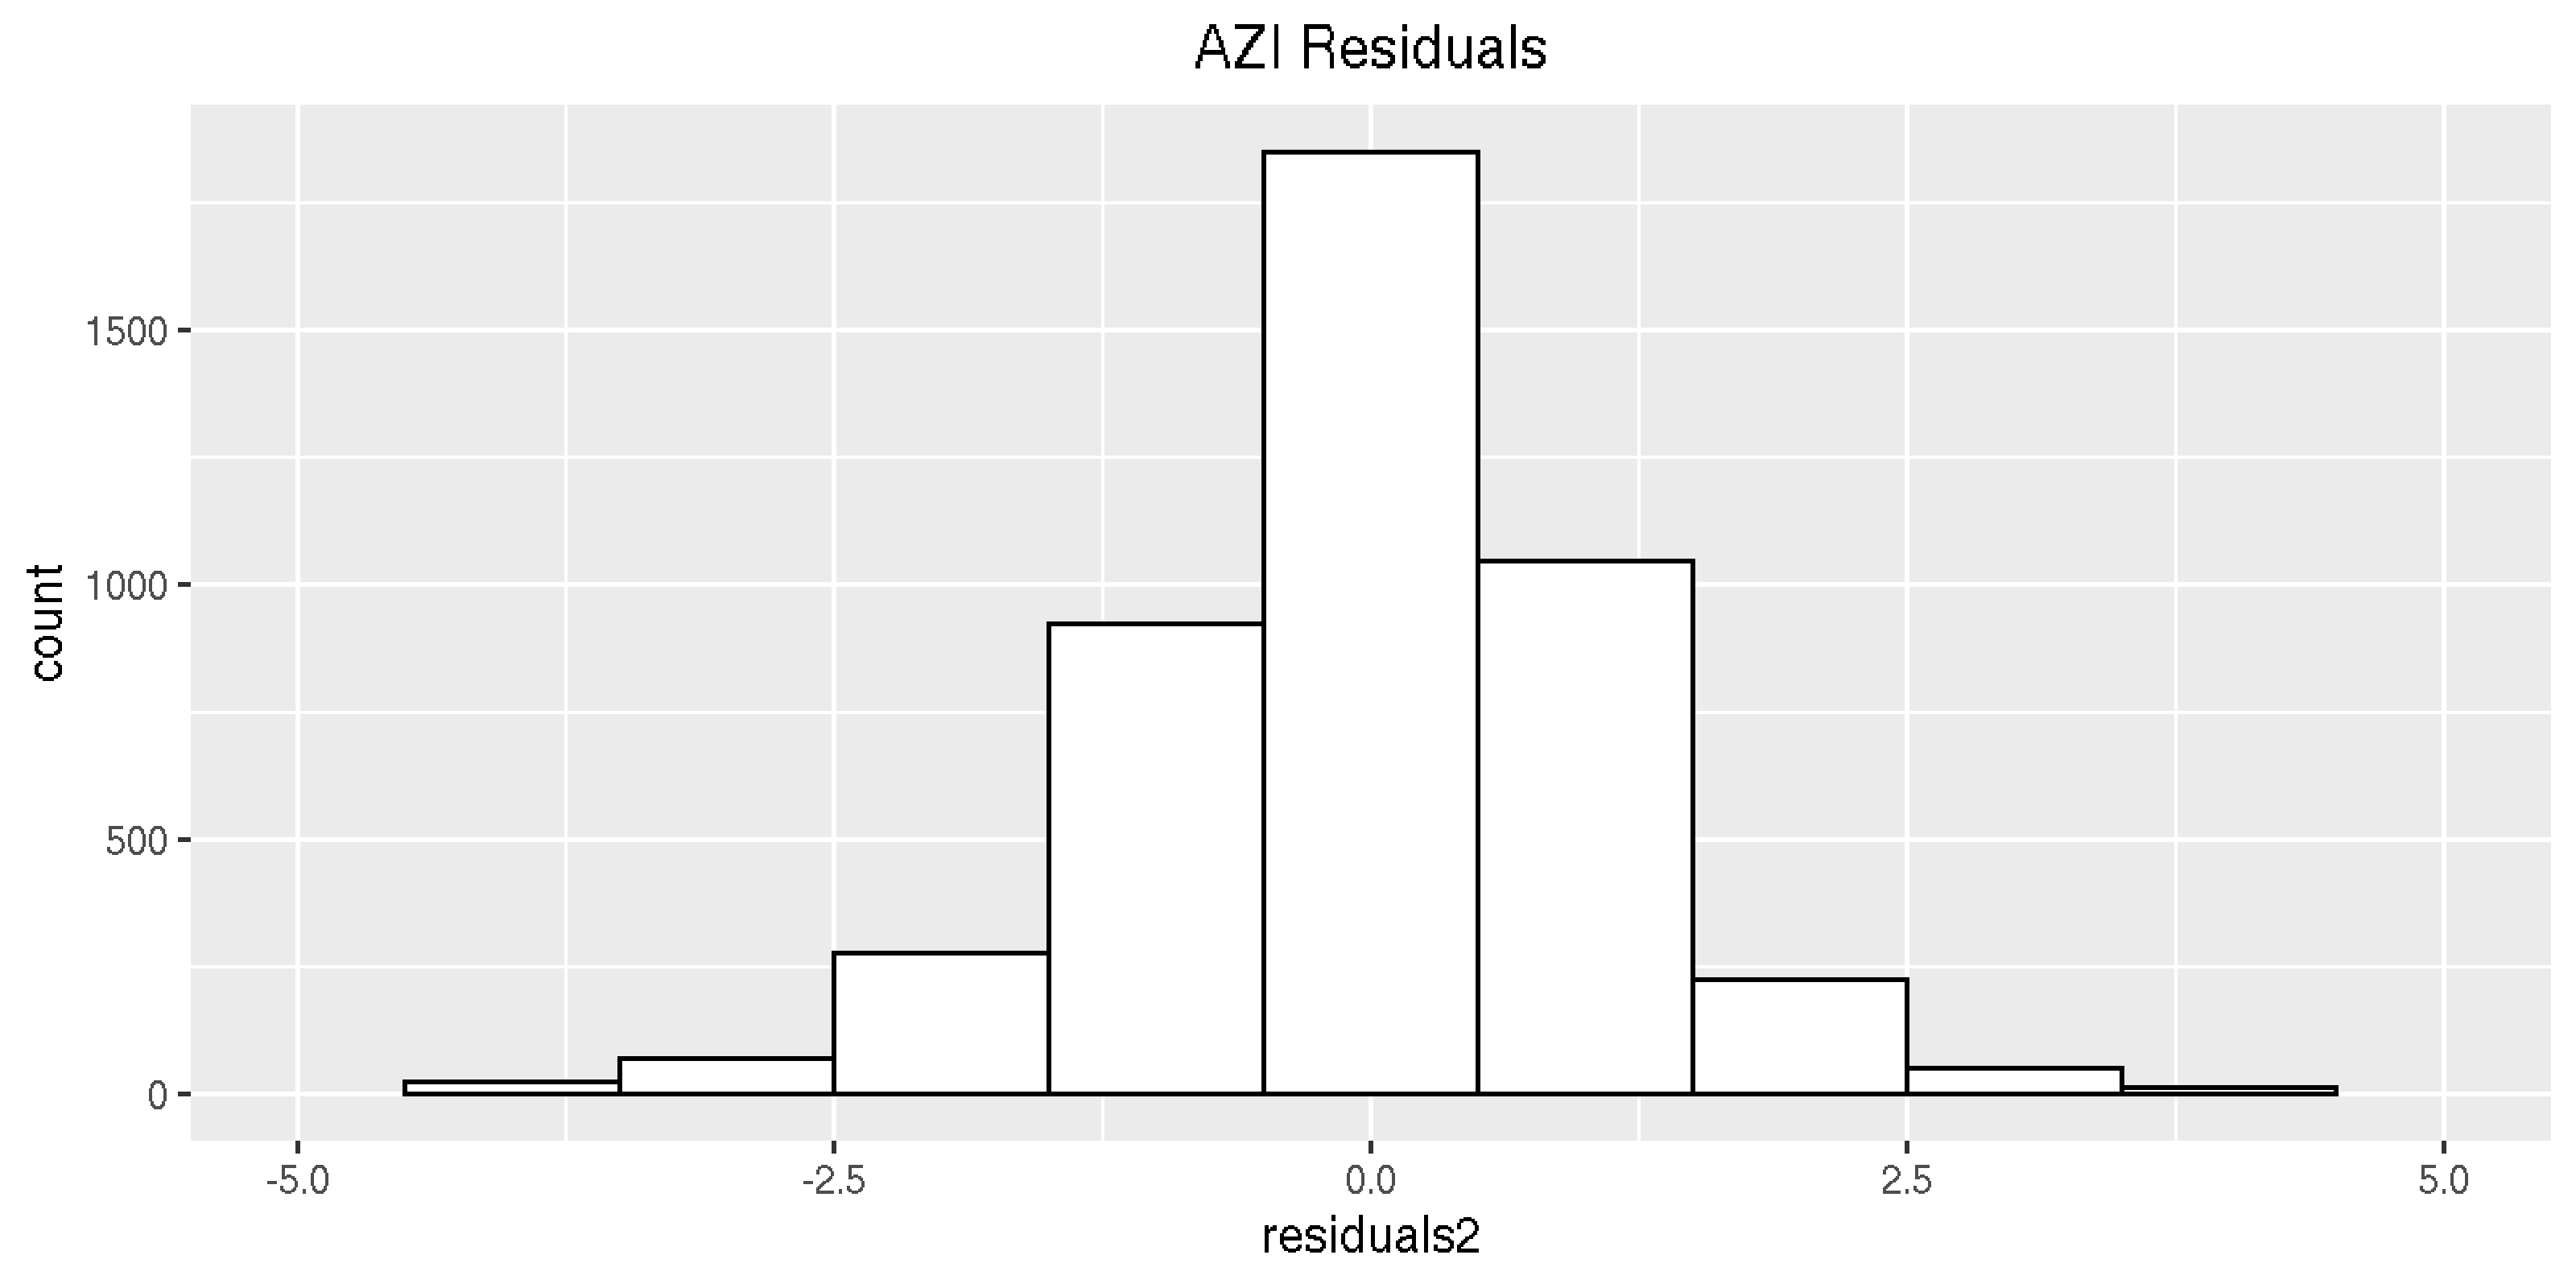

In [7]:
%%R -w 8 -o residuals1 -o residuals2 -h 4 --units in -r 400

print(anova(model1, model2, test='Chisq'))

residuals1 <- resid(model1)
residuals2 <- resid(model2)
ggplot() + aes(residuals2)+ geom_histogram(binwidth=1, colour="black", fill="white") + ggtitle("AZI Residuals") + theme(plot.title = element_text(hjust = 0.5)) + xlim(-5, 5)

Finally, we compare the changes in the number of strains with unexplained susceptibility (defined as actual MIC two dilutions or lower than predicted MIC from the model). This is equivalent to asking about the number of strains with residuals (or model error) less than or equal to -2.

In [11]:
total_n = len(residuals1)
model1_error = sum([True if abs(x) > 2 else False for x in residuals1])
model2_error = sum([True if abs(x) > 2 else False for x in residuals2])
model1_unexpsus = sum([True if x < -2 else False for x in residuals1])
model2_unexpsus = sum([True if x < -2 else False for x in residuals2])

print('''Out of {0} strains with azithromycin MICs, in the baseline model {1} strains ({2}%)
had MICs that deviated by two dilutions or more from predicted MICs. {3} strains ({4}%) had MICs
that were lower than expected, indicating unexplained susceptibility. After addition of MtrC LOFs,
{5} strains ({6}%) had MICs that deviated by two dilutions or more from predicted MICs, and the
number of strains with unexplained susceptibility decreased to {7} strains ({8}%).
'''.format(total_n, model1_error, round(model1_error/total_n*100,2), model1_unexpsus, round(model1_unexpsus/total_n*100,2),
             model2_error, round(model2_error/total_n*100,2), model2_unexpsus, round(model2_unexpsus/total_n*100,2)))

Out of 4505 strains with azithromycin MICs, in the baseline model 434 strains (9.63%)
had MICs that deviated by two dilutions or more from predicted MICs. 258 strains (5.73%) had MICs
that were lower than expected, indicating unexplained susceptibility. After addition of MtrC LOFs,
339 strains (7.52%) had MICs that deviated by two dilutions or more from predicted MICs, and the
number of strains with unexplained susceptibility decreased to 175 strains (3.88%).



### Ceftriaxone

We repeat the same pipeline we used above for azithromycin, but now for ceftriaxone and its resistance determinants.

In [30]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [32]:
%%R -o cro_df -w 8 -h 4 --units in -r 400

library(tidyverse)
library(dplyr)
library(ggplot2)

cro_df = read.table("linear-models/covariates/combined-covariates.csv", sep=",", header=TRUE, comment.char="", na.strings=c("", "NA"), stringsAsFactors=FALSE)
pheno = read.table("metadata/strain-table-filtered.csv", sep=",", header=TRUE, comment.char="", na.strings=c("", "NA"), stringsAsFactors=FALSE)
pheno <- pheno %>%
    select(GWAS_ID, AZI_LOG, CRO_LOG, CIP_LOG, MtrC)

cro_df <- cro_df %>% 
    left_join(pheno, by = c("GWAS_ID")) %>% 
    select(GWAS_ID, Country, CRO_LOG, MtrR_39, MtrR_45, mtr_promoter, 
           mtrR, Mosaic_PenA_BAPS, PBP1_421, PBP2_501, PBP2_542, PBP2_551, PorB_120, PorB_121, MtrC) %>%
    filter(!is.na(CRO_LOG)) %>%

   replace(is.na(.), "Unmapped") %>% # Some mosaic alleles do not map well in SNP calling

    within(., Country <- relevel(factor(Country), ref = "USA")) %>% # Relevel baseline factors to faciliate interpretation
    within(., MtrR_39 <- relevel(factor(MtrR_39), ref = "A")) %>%
    within(., MtrR_45 <- relevel(factor(MtrR_45), ref = "G")) %>%
    within(., PBP1_421 <- relevel(factor(PBP1_421), ref = 'L')) %>%
    within(., PBP2_501 <- relevel(factor(PBP2_501), ref = 'A')) %>%
    within(., PBP2_542 <- relevel(factor(PBP2_542), ref = 'G')) %>%
    within(., PBP2_551 <- relevel(factor(PBP2_551), ref = 'P')) %>%
    within(., PorB_120 <- relevel(factor(PorB_120), ref = 'G')) %>%
    within(., PorB_121 <- relevel(factor(PorB_121), ref = 'A')) %>%
    within(., mtr_promoter <- relevel(factor(mtr_promoter), ref = "A")) %>%
    within(., mtrR <- relevel(factor(mtrR), ref = "full_length")) %>%
    within(., Mosaic_PenA_BAPS <- relevel(factor(Mosaic_PenA_BAPS), ref = '17')) %>%
    within(., MtrC <- relevel(factor(MtrC), ref = "Intact"))

print(dim(cro_df))
head(cro_df, n=10)

[1] 4497   15
      GWAS_ID Country    CRO_LOG MtrR_39 MtrR_45 mtr_promoter        mtrR Mosaic_PenA_BAPS PBP1_421 PBP2_501 PBP2_542 PBP2_551 PorB_120 PorB_121   MtrC
1  SRR1661153  Canada  -3.000000       A       D            - full_length               17        P        A        S        P        K        D Intact
2  SRR1661154  Canada  -3.000000       T       G            - full_length               17        P        V        G        S        K        D Intact
3  SRR1661155  Canada  -2.000000       A       G            - full_length               17        P        A        G        L        K        D Intact
4  SRR1661156  Canada  -3.000000       T       D            - full_length               15        P        V        S        P        K        D Intact
5  SRR1661157  Canada  -3.000000       A       G     Unmapped full_length               17        P        A        S        P        K        D Intact
6  SRR1661158  Canada  -3.000000       A       D            - full_length 

In [5]:
%%R -w 8 -h 4 --units in -r 400

library(jtools)
options(width = 250) 

model1 <- lm(CRO_LOG ~ Country+(.-GWAS_ID-Country-MtrC), data=cro_df, x=TRUE, y=TRUE)
write.csv(tidy(model1) %>% select('term', 'std.error', 'estimate', 'p.value'), 'linear-models/results/lm-CRO.csv', row.names = FALSE)
summary(model1)

model2 <- lm(CRO_LOG ~ Country+(.-GWAS_ID-Country), data=cro_df, x=TRUE, y=TRUE)
write.csv(tidy(model2) %>% select('term', 'std.error', 'estimate', 'p.value'), 'linear-models/results/lm-CRO-mtrC.csv', row.names = FALSE)
summary(model2)


Call:
lm(formula = CRO_LOG ~ Country + (. - GWAS_ID - Country), data = cro_df, 
    x = TRUE, y = TRUE)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.8979 -0.4939 -0.0173  0.4889  6.5431 

Coefficients:
                             Estimate Std. Error t value Pr(>|t|)    
(Intercept)                 -7.157335   0.080932 -88.436  < 2e-16 ***
CountryAngola               -1.350470   0.948259  -1.424 0.154472    
CountryArgentina            -0.828761   0.946534  -0.876 0.381309    
CountryArmenia              -0.489332   0.950257  -0.515 0.606616    
CountryAustralia             0.324231   0.094996   3.413 0.000648 ***
CountryAustria              -0.099069   0.137000  -0.723 0.469637    
CountryBelarus               0.179942   0.198131   0.908 0.363823    
CountryBelgium              -0.539111   0.130906  -4.118 3.89e-05 ***
CountryBhutan               -1.107032   0.431102  -2.568 0.010264 *  
CountryBrazil               -0.235010   0.671688  -0.350 0.726446    
CountryBulgaria 

Multiple R-squared:  0.698,	Adjusted R-squared:  0.6904 
F-statistic: 92.14 on 110 and 4386 DF,  p-value: < 2.2e-16



In [7]:
%%R -w 8 -o residuals1 -o residuals2 -h 4 --units in -r 400

print(anova(model1, model2, test='Chisq'))

residuals1 <- resid(model1)
residuals2 <- resid(model2)
#ggplot() + aes(residuals2)+ geom_histogram(binwidth=1, colour="black", fill="white") + ggtitle("CRO Residuals") + theme(plot.title = element_text(hjust = 0.5)) + xlim(-5, 5)

Analysis of Variance Table

Model 1: CRO_LOG ~ Country + ((GWAS_ID + Country + MtrR_39 + MtrR_45 + 
    mtr_promoter + mtrR + Mosaic_PenA_BAPS + PBP1_421 + PBP2_501 + 
    PBP2_542 + PBP2_551 + PorB_120 + PorB_121 + MtrC) - GWAS_ID - 
    Country - MtrC)
Model 2: CRO_LOG ~ Country + ((GWAS_ID + Country + MtrR_39 + MtrR_45 + 
    mtr_promoter + mtrR + Mosaic_PenA_BAPS + PBP1_421 + PBP2_501 + 
    PBP2_542 + PBP2_551 + PorB_120 + PorB_121 + MtrC) - GWAS_ID - 
    Country)
  Res.Df    RSS Df Sum of Sq  Pr(>Chi)    
1   4387 4130.0                           
2   4386 3921.5  1    208.52 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [8]:
total_n = len(residuals1)
model1_error = sum([True if abs(x) > 2 else False for x in residuals1])
model2_error = sum([True if abs(x) > 2 else False for x in residuals2])
model1_unexpsus = sum([True if x < -2 else False for x in residuals1])
model2_unexpsus = sum([True if x < -2 else False for x in residuals2])

print('''Out of {0} strains with ceftriaxone MICs, in the baseline model {1} strains ({2}%)
had MICs that deviated by two dilutions or more from predicted MICs. {3} strains ({4}%) had MICs
that were lower than expected, indicating unexplained susceptibility. After addition of MtrC LOFs,
{5} strains ({6}%) had MICs that deviated by two dilutions or more from predicted MICs, and the
number of strains with unexplained susceptibility decreased to {7} strains ({8}%).
'''.format(total_n, model1_error, round(model1_error/total_n*100,2), model1_unexpsus, round(model1_unexpsus/total_n*100,2),
             model2_error, round(model2_error/total_n*100,2), model2_unexpsus, round(model2_unexpsus/total_n*100,2)))

Out of 4497 strains with ceftriaxone MICs, in the baseline model 183 strains (4.07%)
had MICs that deviated by two dilutions or more from predicted MICs. 91 strains (2.02%) had MICs
that were lower than expected, indicating unexplained susceptibility. After addition of MtrC LOFs,
163 strains (3.62%) had MICs that deviated by two dilutions or more from predicted MICs, and the
number of strains with unexplained susceptibility decreased to 78 strains (1.73%).



### Ciprofloxacin

We repeat the same pipeline we used above for azithromycin, but now for ciprofloxacin and its resistance determinants.

In [1]:
%load_ext rpy2.ipython

In [10]:
%%R -o cip_df -w 8 -h 4 --units in -r 400

library(tidyverse)
library(dplyr)
library(ggplot2)

cip_df = read.table("linear-models/covariates/combined-covariates.csv", sep=",", header=TRUE, comment.char="", na.strings=c("", "NA"), stringsAsFactors=FALSE)
pheno = read.table("metadata/strain-table-filtered.csv", sep=",", header=TRUE, comment.char="", na.strings=c("", "NA"), stringsAsFactors=FALSE)
pheno <- pheno %>%
    select(GWAS_ID, AZI_LOG, CRO_LOG, CIP_LOG, MtrC)

cip_df <- cip_df %>% 
    left_join(pheno, by = c("GWAS_ID")) %>% 
    select(GWAS_ID, Country, CIP_LOG, MtrR_39, MtrR_45, mtr_promoter, 
           mtrR, GyrA_91, GyrA_95, ParC_86, ParC_87, ParC_91, PorB_120, PorB_121, MtrC) %>%
    filter(!is.na(CIP_LOG)) %>%

   replace(is.na(.), "Unmapped") %>% # Some mosaic alleles do not map well in SNP calling

    within(., Country <- relevel(factor(Country), ref = "USA")) %>% # Relevel baseline factors to faciliate interpretation
    within(., MtrR_39 <- relevel(factor(MtrR_39), ref = "A")) %>%
    within(., MtrR_45 <- relevel(factor(MtrR_45), ref = "G")) %>%
    within(., GyrA_91 <- relevel(factor(GyrA_91), ref = 'S')) %>%
    within(., GyrA_95 <- relevel(factor(GyrA_95), ref = 'D')) %>%
    within(., ParC_86 <- relevel(factor(ParC_86), ref = 'G')) %>%
    within(., ParC_87 <- relevel(factor(ParC_87), ref = 'S')) %>%
    within(., ParC_91 <- relevel(factor(ParC_91), ref = 'E')) %>%
    within(., PorB_120 <- relevel(factor(PorB_120), ref = 'G')) %>%
    within(., PorB_121 <- relevel(factor(PorB_121), ref = 'A')) %>%
    within(., mtr_promoter <- relevel(factor(mtr_promoter), ref = "A")) %>%
    within(., mtrR <- relevel(factor(mtrR), ref = "full_length")) %>%
    within(., MtrC <- relevel(factor(MtrC), ref = "Intact"))

print(dim(cip_df))
head(cip_df, n=10)

[1] 4135   15
      GWAS_ID Country   CIP_LOG MtrR_39 MtrR_45 mtr_promoter        mtrR GyrA_91 GyrA_95 ParC_86 ParC_87 ParC_91 PorB_120 PorB_121   MtrC
1  SRR1661153  Canada -5.965784       A       D            - full_length       S       D       G       S       E        K        D Intact
2  SRR1661154  Canada -1.000000       T       G            - full_length       Y       D       G       S       E        K        D Intact
3  SRR1661155  Canada -5.965784       A       G            - full_length       S       D       G       S       E        K        D Intact
4  SRR1661156  Canada  4.000000       T       D            - full_length       F       G       G       S       G        K        D Intact
5  SRR1661157  Canada -5.965784       A       G     Unmapped full_length       S       D       G       S       E        K        D Intact
6  SRR1661158  Canada -1.000000       A       D            - full_length       F       D       G       S       E        K        N Intact
7  SRR1661159  Canad

In [3]:
%%R -w 8 -h 4 --units in -r 400

library(jtools)
options(width = 250) 

model1 <- lm(CIP_LOG ~ Country+(.-GWAS_ID-Country-MtrC), data=cip_df, x=TRUE, y=TRUE)
write.csv(tidy(model1) %>% select('term', 'std.error', 'estimate', 'p.value'), 'linear-models/results/lm-CIP.csv', row.names = FALSE)
summary(model1)

model2 <- lm(CIP_LOG ~ Country+(.-GWAS_ID-Country), data=cip_df, x=TRUE, y=TRUE)
write.csv(tidy(model2) %>% select('term', 'std.error', 'estimate', 'p.value'), 'linear-models/results/lm-CIP-mtrC.csv', row.names = FALSE)
summary(model2)


Call:
lm(formula = CIP_LOG ~ Country + (. - GWAS_ID - Country), data = cip_df, 
    x = TRUE, y = TRUE)

Residuals:
     Min       1Q   Median       3Q      Max 
-12.5298  -0.6592   0.0182   0.5221  14.0042 

Coefficients:
                       Estimate Std. Error  t value Pr(>|t|)    
(Intercept)          -7.7216648  0.0647762 -119.205  < 2e-16 ***
CountryAngola        -0.7760453  1.3764501   -0.564 0.572920    
CountryArgentina      0.6389922  1.3764501    0.464 0.642507    
CountryArmenia        0.3408430  1.3767808    0.248 0.804483    
CountryAustralia      1.1182057  0.1386082    8.067 9.38e-16 ***
CountryBelarus       -0.0102696  0.3574475   -0.029 0.977081    
CountryBelgium       -0.1185138  0.1898695   -0.624 0.532541    
CountryBhutan        -2.9402808  0.6292084   -4.673 3.07e-06 ***
CountryBrazil        -1.4269425  0.9779259   -1.459 0.144601    
CountryBulgaria      -0.7560068  1.3768564   -0.549 0.582980    
CountryCabo Verde    -0.2690012  0.9818766   -0.274 0.784124 

In [11]:
%%R -w 8 -o residuals1 -o residuals2 -h 4 --units in -r 400

print(anova(model1, model2, test='Chisq'))

residuals1 <- resid(model1)
residuals2 <- resid(model2)
#ggplot() + aes(residuals2)+ geom_histogram(binwidth=1, colour="black", fill="white") + ggtitle("CRO Residuals") + theme(plot.title = element_text(hjust = 0.5)) + xlim(-5, 5)

Analysis of Variance Table

Model 1: CIP_LOG ~ Country + ((GWAS_ID + Country + MtrR_39 + MtrR_45 + 
    mtr_promoter + mtrR + GyrA_91 + GyrA_95 + ParC_86 + ParC_87 + 
    ParC_91 + PorB_120 + PorB_121 + MtrC) - GWAS_ID - Country - 
    MtrC)
Model 2: CIP_LOG ~ Country + ((GWAS_ID + Country + MtrR_39 + MtrR_45 + 
    mtr_promoter + mtrR + GyrA_91 + GyrA_95 + ParC_86 + ParC_87 + 
    ParC_91 + PorB_120 + PorB_121 + MtrC) - GWAS_ID - Country)
  Res.Df    RSS Df Sum of Sq  Pr(>Chi)    
1   4037 7812.6                           
2   4036 7633.4  1    179.22 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [12]:
total_n = len(residuals1)
model1_error = sum([True if abs(x) > 2 else False for x in residuals1])
model2_error = sum([True if abs(x) > 2 else False for x in residuals2])
model1_unexpsus = sum([True if x < -2 else False for x in residuals1])
model2_unexpsus = sum([True if x < -2 else False for x in residuals2])

print('''Out of {0} strains with ceftriaxone MICs, in the baseline model {1} strains ({2}%)
had MICs that deviated by two dilutions or more from predicted MICs. {3} strains ({4}%) had MICs
that were lower than expected, indicating unexplained susceptibility. After addition of MtrC LOFs,
{5} strains ({6}%) had MICs that deviated by two dilutions or more from predicted MICs, and the
number of strains with unexplained susceptibility decreased to {7} strains ({8}%).
'''.format(total_n, model1_error, round(model1_error/total_n*100,2), model1_unexpsus, round(model1_unexpsus/total_n*100,2),
             model2_error, round(model2_error/total_n*100,2), model2_unexpsus, round(model2_unexpsus/total_n*100,2)))

Out of 4135 strains with ceftriaxone MICs, in the baseline model 207 strains (5.01%)
had MICs that deviated by two dilutions or more from predicted MICs. 120 strains (2.9%) had MICs
that were lower than expected, indicating unexplained susceptibility. After addition of MtrC LOFs,
178 strains (4.3%) had MICs that deviated by two dilutions or more from predicted MICs, and the
number of strains with unexplained susceptibility decreased to 100 strains (2.42%).



## N. meningitidis analysis

We then extended our findings by analyzing a urogenital clade of N. meningitidis.

In [2]:
cd mening

/n/data1/hsph/immid/grad/Kevin/gonococcus/pyseer/mtrC-gwas-manuscript/mening
